# "Cross-validation" des modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [2]:
def get_data(
            N = 50,
            p0 = 0.15,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6):
    
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y


In [3]:
import torch
criterion = torch.nn.BCELoss()

def fit_data(theta, y, 
                learning_rate = 0.005,
                num_epochs = 1000,
                verbose=False):
    torch.set_default_tensor_type('torch.DoubleTensor')
    from torch.nn import functional as F

    class LogisticRegressionModel(torch.nn.Module):
        def __init__(self):
            super(LogisticRegressionModel, self).__init__()
            self.linear = torch.nn.Linear(1, 1)    
            self.logit0 = torch.nn.Linear(1, 1) 

        def forward(self, x):
            p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
            out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
            return out

    logistic_model = LogisticRegressionModel()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)

    theta, p, y = get_data()
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    for epoch in range(int(num_epochs)):

        optimizer.zero_grad()
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print Loss
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch}. Loss: {loss.item():.5f}.")

    logistic_model.eval()
    return logistic_model, loss.item()

kezako?

In [4]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0. Loss: 0.72927.
Iteration: 312. Loss: 0.58313.
Iteration: 624. Loss: 0.47703.
Iteration: 936. Loss: 0.43957.
Iteration: 1248. Loss: 0.42406.
Iteration: 1560. Loss: 0.41723.
Iteration: 1872. Loss: 0.41423.
Iteration: 2184. Loss: 0.41297.
Iteration: 2496. Loss: 0.41246.
Iteration: 2808. Loss: 0.41226.
Iteration: 3120. Loss: 0.41216.
Iteration: 3432. Loss: 0.41209.
Iteration: 3744. Loss: 0.41204.
Iteration: 4056. Loss: 0.41200.
Iteration: 4368. Loss: 0.41197.
Iteration: 4680. Loss: 0.41194.
Iteration: 4992. Loss: 0.41192.
Iteration: 5304. Loss: 0.41190.
Iteration: 5616. Loss: 0.41188.
Iteration: 5928. Loss: 0.41186.
Iteration: 6240. Loss: 0.41185.
Iteration: 6552. Loss: 0.41184.
Iteration: 6864. Loss: 0.41183.
Iteration: 7176. Loss: 0.41182.
Iteration: 7488. Loss: 0.41182.
Iteration: 7800. Loss: 0.41181.
Iteration: 8112. Loss: 0.41181.
Iteration: 8424. Loss: 0.41180.
Iteration: 8736. Loss: 0.41180.
Iteration: 9048. Loss: 0.41180.
Iteration: 9360. Loss: 0.41179.
Iteration: 967

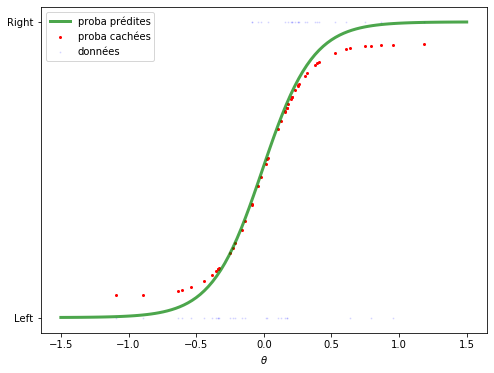

In [5]:
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


## validation

loss= tensor(0.6005, grad_fn=<BinaryCrossEntropyBackward>)


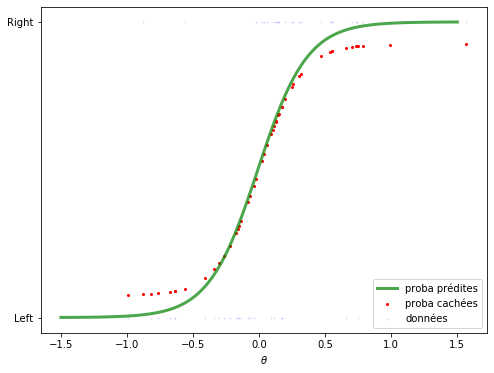

In [6]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [7]:
Ns = np.logspace(1, 4, 15, base=10)
losses, KLs = [], []
for N_ in Ns:
    theta, p, y = get_data(N=int(N_))
    logistic_model, loss = fit_data(theta, y, verbose=False)
    theta, p, y = get_data(N=1000) # nouvelles données 
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item()
    KL = criterion(outputs, torch.Tensor(p[:, None])).item()
    print(f"N: {int(N_)}, Loss: {loss:.5f}, KL: {KL:.5f}.")
    KLs.append(KL)
    losses.append(loss)

Text(0, 0.5, ' Loss ')

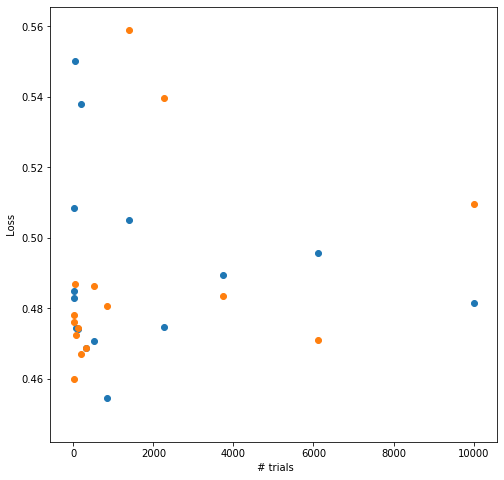

In [10]:
plt.figure(figsize = (8,8)) 
plt.scatter(Ns, losses)
plt.scatter(Ns, KLs)
plt.xlabel(' # trials')
plt.ylabel(' Loss ')

## influence du nombre du learning rate


In [8]:
learning_rate = 0.005
num_epochs = 1e4

learning_rates = learning_rate * np.logspace(-1, 1, 15, base=10)
losses, KLs = [], []
for learning_rate_ in learning_rates:
    theta, p, y = get_data()
    logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)
    
    theta, p, y = get_data(N=1000) # nouvelles données 
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    outputs = logistic_model(Theta)

    loss = criterion(outputs, labels).item()
    KL = criterion(outputs, torch.Tensor(p[:, None])).item()
    print(f"learning_rate: {learning_rate_}, Loss: {loss:.5f}, KL: {KL:.5f}.")
    KLs.append(KL)
    losses.append(loss)

Text(0, 0.5, ' Loss ')

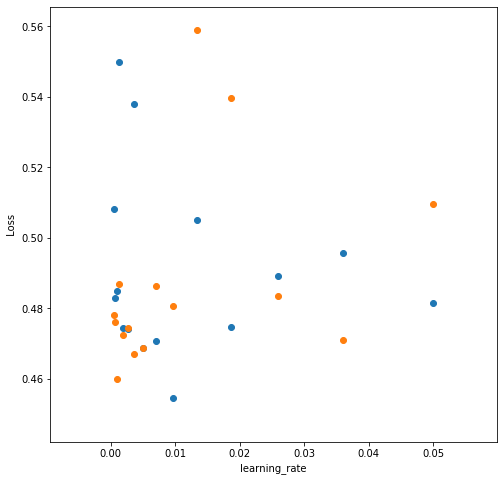

In [11]:
plt.figure(figsize = (8,8)) 
plt.scatter(learning_rates, losses)
plt.scatter(learning_rates, KLs)

plt.xlabel('learning_rate')
plt.ylabel(' Loss ')

## influence du nombre du nombre d'epochs

In [9]:
num_epochss = num_epochs * np.logspace(-1, 1, 15, base=10)
losses, KLs = [], []
for num_epochs_ in num_epochss:
    theta, p, y = get_data()
    logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
    theta, p, y = get_data(N=1000) # nouvelles données 
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    outputs = logistic_model(Theta)

    loss = criterion(outputs, labels).item()
    KL = criterion(outputs, torch.Tensor(p[:, None])).item()
    print(f"num_epochs: {int(N_)}, Loss: {loss:.5f}, KL: {KL:.5f}.")
    KLs.append(KL)
    losses.append(loss)

Text(0, 0.5, ' Loss ')

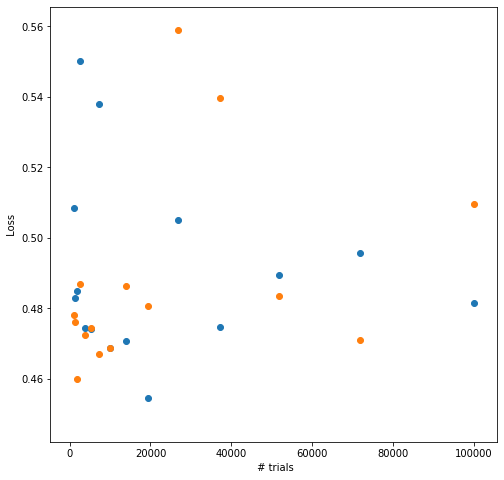

In [12]:
plt.figure(figsize = (8,8)) 
plt.scatter(num_epochss, losses)
plt.scatter(num_epochss, KLs)
plt.xlabel(' num_epochss')
plt.ylabel(' Loss ')